In [1]:
%load_ext jbmagics

Exception reporting mode: Minimal


# Using `modflowapi`

Let's modify the river conductance at model run time.
We use [`modflowapi`](https://github.com/MODFLOW-USGS/modflowapi).

In [2]:
import numpy as np

import modflowapi

import pymf6
from pymf6tools.custom_print import CustomPrint

from helpers import make_model_input, get_flux, plot

An instance of this class is a callable that `modflowapi` will cal for each
modeling time step:

In [3]:
%%include dynamic_cond_api.py
import_module = True

```python
"""
Dynamic river conductance with `modflowapi`.

Based on:
https://github.com/jdhughes-usgs/modflow-dsd24/blob/main/notebooks/5_MODFLOW_API/modflow_api.ipynb
"""

from modflowapi import Callbacks

class DynamicCond:
    """
    Dynamic conductance.

    An example class that sets the river conductance based
    on the gradient between the river cell and the head
    in the groundwater cell. A reduced river conductance
    value is used when the flow is from the river cell to
    the aquifer. This class could be adapted to modify other
    stress packages or monitor other simulated stress
    packages fluxes by modifying this callback class.

    Parameters
    ----------
    vmin : float
        minimum head value for color scaling on the plot
    vmax : float
        maximum head value for color scaling on the plot
    ntimes : int
        number of time steps
    h_mean : float
        mean water level during the simulation
    """

    def __init__(self, name, h_mean):
        self.name = name
        self.h_mean = h_mean
        self.condref = None
        # flux in river cell
        self.flux_river = [0.0]
        # flux in cell below river
        self.flux_gw = [0.0]
        # "pointers" to MF6 variables
        self.sim_river = None
        self.sim_chd = None
        self.model = None

    def __call__(self, sim, callback_step):
        """
        Callable that is called for each time step.

        A demonstration function that dynamically adjusts the CHD
        boundary conditions each stress period in a MODFLOW 6 model
        through the MODFLOW-API and then updates heads on a matplotlib
        plot for each timestep.

        Parameters
        ----------
        sim : modflowapi.Simulation
            A simulation object for the solution group that is
            currently being solved
        callback_step : enumeration
            modflowapi.Callbacks enumeration object that indicates
            the part of the solution modflow is currently in.
        """
        if callback_step == Callbacks.initialize:
            ml = sim.get_model()
            river_tag = ml.mf6.get_var_address("SIMVALS", self.name.upper(), "RIVER")
            self.sim_river = ml.mf6.get_value_ptr(river_tag)
            chd_tag = ml.mf6.get_var_address("SIMVALS", self.name.upper(), "CHD_0")
            self.sim_chd = ml.mf6.get_value_ptr(chd_tag)
            self.model = getattr(sim, self.name)


        if callback_step == Callbacks.iteration_start:
            spd = self.model.river.stress_period_data.values
            if self.condref is None:
                self.condref = spd[0][2]
            if self.model.X[0, 0, 0] > self.h_mean:
                cond = self.condref
            else:
                cond = self.condref * 0.10
            spd[0] = ((0, 0, 0), self.h_mean, cond, 319.0)
            self.model.river.stress_period_data.values = spd

        if callback_step == Callbacks.timestep_end:
            ml = sim.get_model()
            self.flux_river.append(float(self.sim_river.sum()))
            self.flux_gw.append(float(self.sim_chd[0]))

        if callback_step == Callbacks.finalize:
            pass
            # cleanup would be here
```


We use this class to interact wit MF6.
We need the path to shared library:

In [4]:
libmf6 = pymf6.info['dll_path']
name = 'rivercond'

These a the arguments for the class instance:

This instance:

In [5]:
dyn_cond = DynamicCond(name=name, h_mean=320.0)

can be used inside the MF6 run:

In [6]:
modflowapi.run_simulation(dll=libmf6, sim_path=name, callback=dyn_cond)

NORMAL TERMINATION OF SIMULATION


The fluxes are now cut off for the time when the stream is losing:

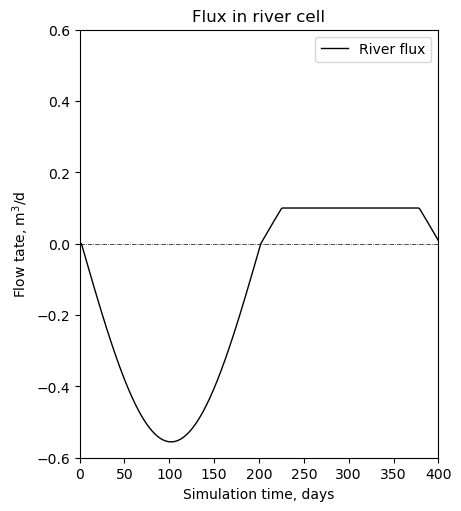

In [7]:
plot(dyn_cond.flux_river);

The flux in the cell below the river is has the same numerical but the opposite sign:

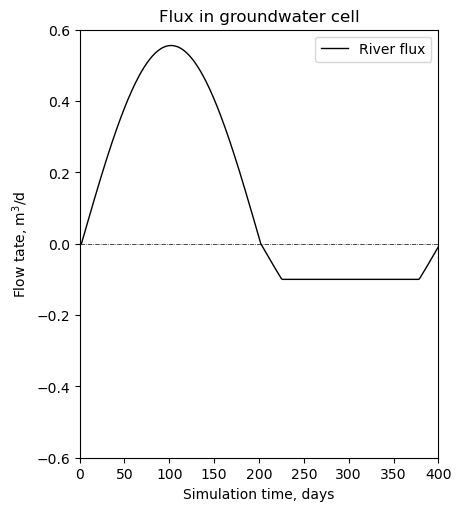

In [8]:
plot(dyn_cond.flux_gw, cell_name='groundwater');

The differences are with numerical errors:

In [9]:
np.allclose(dyn_cond.flux_gw, -np.array(dyn_cond.flux_river))

True